## Variational Auto-Encoder (VAE) PyTorch implementation
Evolution of the auto-encoder neural network to reduce dimensionality of an airfoil defined by 30 coordinates.  
Papers:
- Larsen et al.: "Autoencoding beyond pixels using a learned similarity metric" - https://arxiv.org/abs/1512.09300
- Wang et al.: "Airfoil GAN: Encoding and Synthesizing Airfoils forAerodynamic-aware Shape Optimization" - https://arxiv.org/abs/2101.04757

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from types_ import *

plt.style.use('seaborn-whitegrid')

In [2]:
# Library options
pd.options.mode.chained_assignment = None  # default='warn'

# Get CPU or GPU device for NN
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
print(f"CUDA version: {torch.version.cuda}")

Using cuda device
CUDA version: 10.2


### Helper functions

In [3]:
def airfoil_info(airfoil_df, plot_airfoil, mach=0.1, reynolds=1e5):
    """
    Returns a plot of a NACA airfoil's shape, Cl and Cd between alpha = -10 and alpha = 10 degrees. 
    Assumes 15 points for upper surface and 15 points for lower surface.
    Inputs:
        - airfoil_df: pandas dataframe with airfoil data
        - plot_airfoil: index that specifies which airfoil to plot
    Outputs:
        - Plot of airfoil shape, Cl and Cd
    """
    # X coordinates
    x = [0.5*(1-np.cos(ang)) for ang in np.linspace(0,np.pi,17)]
    aux_x = list(reversed([0.5*(1-np.cos(ang)) for ang in np.linspace(0,np.pi,17)[1:16]]))
    [x.append(i) for i in aux_x]
    x.append(0)
    
    first_coord_list = airfoil_df.loc[(airfoil_df['MachNumber'] == mach) & (airfoil_df['ReynoldsNumber'] == reynolds)]['yU_1'].unique()
    plot_airfoil_df = airfoil_df.loc[(airfoil_df['MachNumber'] == mach) & (airfoil_df['ReynoldsNumber'] == reynolds) & (airfoil_df['yU_1']==first_coord_list[plot_airfoil])]
    
    # Y coordinates
    y = []
    origin = (plot_airfoil_df.iloc[1][0]+plot_airfoil_df.iloc[1][15])/2
    y.append(origin)
    [y.append(j) for j in plot_airfoil_df.iloc[1][0:15].values.tolist()]
    y.append(0)
    aux_y = list(reversed(plot_airfoil_df.iloc[1][15:30].values.tolist()))
    [y.append(k) for k in aux_y]
    y.append(origin)
    
    # Cl, Cd, alphas
    Cl = plot_airfoil_df['Cl'].values.tolist()[0:21]
    Cd = plot_airfoil_df['Cd'].values.tolist()[0:21]
    alphas = np.linspace(-10,10,len(Cl))
    
    # Airfoil plot
    plot1 = plt.subplot2grid((2,2), (0,0), colspan = 2)
    plot2 = plt.subplot2grid((2,2), (1,0))
    plot3 = plt.subplot2grid((2,2), (1,1))
    
    plot1.plot(x, y)
    plot1.set_xlim([-0.1,1.1])
    plot1.set_ylim([np.min(y)-0.2*np.abs(np.min(y)),np.max(y)+0.2*np.abs(np.max(y))])
    plot1.set_ylabel('$y/c$')
    plot1.set_xlabel('$x/c$') 
    plot1.set_title('Airfoil plot', fontsize=16)
    
    plot2.plot(alphas, Cl)
    plot2.set_xlim([-10,10])
    plot2.set_ylim([np.min(Cl)-0.1*np.abs(np.min(Cl)),np.max(Cl)+0.1*np.abs(np.max(Cl))])
    plot2.set_ylabel('$C_L$')
    plot2.set_xlabel('$\\alpha$ [$^\\circ$]') 
    
    plot3.plot(alphas, Cd)
    plot3.set_xlim([-10,10])
    plot3.set_ylim([np.min(Cd)-0.1*np.abs(np.min(Cd)),np.max(Cd)+0.1*np.abs(np.max(Cd))])
    plot3.set_ylabel('$C_D$')
    plot3.set_xlabel('$\\alpha$ [$^\\circ$]') 
 
    plt.tight_layout()
    plt.show()
    return

def airfoil_plot(airfoil_coords, fig=None, label=None):
    """
    Returns a plot of an airfoil. Used to visualize output of the optimizer. 
    Assumes 15 points for upper surface and 15 points for lower surface, with cosine spacing.
    Inputs:
        - airfoil_coords: pandas DataFrame with airfoil coordinates and other parameters
    Outputs:
        - Plot of airfoil shape
    """
    if fig==None:
        fig = plt.subplot2grid((1,3), (0,0), colspan = 3)
    # X coordinates
    x = [0.5*(1-np.cos(ang)) for ang in np.linspace(0,np.pi,17)]
    aux_x = list(reversed([0.5*(1-np.cos(ang)) for ang in np.linspace(0,np.pi,17)[1:16]]))
    [x.append(i) for i in aux_x]
    x.append(0)
    
    # Y coordinates
    y = []
    origin = (airfoil_coords.iloc[0][0]+airfoil_coords.iloc[0][15])/2
    y.append(origin)
    [y.append(j) for j in airfoil_coords.iloc[0][0:15].values.tolist()]
    y.append(0)
    aux_y = list(reversed(airfoil_coords.iloc[0][15:30].values.tolist()))
    [y.append(k) for k in aux_y]
    y.append(origin)
    
    # Airfoil plot     
    fig.plot(x, y, label = label)
    fig.set_xlim([-0.1,1.1])
    fig.set_ylim([-0.2,0.3])
    fig.set_ylabel('$y/c$')
    fig.set_xlabel('$x/c$') 
    fig.set_title('Airfoil plot', fontsize=16)
    fig.legend()
    if fig==None:
        plt.show()
    return


def torch_test_split(X, y, test_size=0.2, seed=1234):
    """
    Returns a train and test set in PyTorch tensor format from a numpy array dataset.
    Inputs:
        - X: numpy array with input data. Each row is a training/testing sample and each column is a feature.
        - y: numpy array with output data. Each row is a training/testing sample and each column is an output.
        - test_size: proportion of the dataset to be used as test set.
        - seed: random seed for reproducibility.
    Outputs:
        - training_data: PyTorch tensor with training data.
        - test_data: PyTorch tensor with test data.
    """
    X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X, y, test_size=test_size, random_state=seed)
    X_train = torch.from_numpy(X_train_0).float()
    X_test = torch.from_numpy(X_test_0).float()
    y_train = torch.from_numpy(y_train_0).float()
    y_test = torch.from_numpy(y_test_0).float()
    training_data = []
    testing_data = []
    for i in range(len(X_train)):
        training_data.append((X_train[i], y_train[i]))
    for i in range(len(X_test)):
        testing_data.append((X_test[i], y_test[i]))
    return training_data, testing_data

def normalize_data (data, scaler):
    """
    Normalizes neural network inputs and outputs.
    Inputs:
        - data: data to be normalized. [np.array / pd.DataFrame]
        - scaler: pre-fitted scaler object.
    Outputs:
        - normalized data. [pd.DataFrame]
    """
    if type(data) == pd.DataFrame:
        data = data.to_numpy().reshape(-1,scaler.n_features_in_)
    elif type(data) == np.ndarray:
        data = data.reshape(-1,scaler.n_features_in_)
    else:
        raise(TypeError('Input data must be either a pd.DataFrame or a np.ndarray'))
    norm_data = pd.DataFrame(data = scaler.transform(data), columns = scaler.feature_names_in_)
    return norm_data

def denormalize_data (data, scaler):
    """
    Denormalizes neural network inputs and outputs.
    Inputs:
        - data: data to be denormalized. [np.array / pd.DataFrame]
        - scaler: pre-fitted scaler object.
    Outputs:
        - denormalized data. [pd.DataFrame]
    """
    if type(data) == pd.DataFrame:
        data = data.to_numpy().reshape(-1,scaler.n_features_in_)
    elif type(data) == np.ndarray:
        data = data.reshape(-1,scaler.n_features_in_)
    else:
        raise(TypeError('Input data must be either a pd.DataFrame or a np.ndarray'))
    denorm_data = pd.DataFrame(data = scaler.inverse_transform(data), columns = scaler.feature_names_in_)
    return denorm_data


### Input data analysis

In [4]:
# Define input dataset (.csv) name and path
data_folder = './data/'
dataset_name = 'NACA4Digit_Dataset15Point.csv'

# Import dataset
airfoil_df = pd.read_csv(data_folder + dataset_name)
airfoil_df = airfoil_df.drop('Unnamed: 0', axis=1)    # Remove first column, counter
airfoil_df = airfoil_df.drop_duplicates(subset=['yU_1'], keep='first')    # Remove duplicate airfoil coordinates

# Get rid of duplicates
# airfoil_df = airfoil_df.drop_duplicates(subset=['yU_1', 'yL_1', 'ReynoldsNumber', 'MachNumber', 'alpha', 'Cl','Cd','Cm'])

airfoil_df.head()

,yU_1,yU_2,yU_3,yU_4,yU_5,yU_6,yU_7,yU_8,yU_9,yU_10,...,yL_12,yL_13,yL_14,yL_15,ReynoldsNumber,MachNumber,alpha,Cl,Cd,Cm
0,0.006923,0.013103,0.018233,0.022013,0.024229,0.024823,0.023923,0.021796,0.018781,0.015248,...,-0.007926,-0.004725,-0.002193,-0.000563,100000,0.1,-10,-0.334,0.16140,0.001
315,0.013846,0.026207,0.036466,0.044027,0.048457,0.049647,0.047845,0.043592,0.037561,0.030495,...,-0.015853,-0.009451,-0.004386,-0.001126,100000,0.1,-10,-0.800,0.07872,0.003
630,0.020769,0.039310,0.054699,0.066040,0.072686,0.074470,0.071768,0.065388,0.056342,0.045743,...,-0.023779,-0.014176,-0.006579,-0.001690,100000,0.1,-10,-1.051,0.03804,0.008
945,0.027692,0.052414,0.072932,0.088053,0.096914,0.099294,0.095691,0.087184,0.075122,0.060990,...,-0.031706,-0.018901,-0.008772,-0.002253,100000,0.1,-10,-1.146,0.03410,0.011
1260,0.034615,0.065517,0.091165,0.110067,0.121143,0.124117,0.119614,0.108980,0.093903,0.076238,...,-0.039632,-0.023626,-0.010965,-0.002816,100000,0.1,-10,-1.188,0.03644,0.013


## 2. Variational Autoencoder model
In this section, an MLP based variational encoder-decoder network will be created and trained to process airfoil coordinates and recreate them from a set of latent variables characterized by their mean $\mu$ and standard deviation $\sigma$.

**Inputs**
- Upper surface coordinates (15)
- Lower surface coordinates (15)

**Outputs**
- Approximately the same coordinates (network will be trained to do so)

There will be a layer in the middle that will encode the _latent feature_ distributions of the set. This is akin to a parameterization method, with arbitrary parameters.

In [5]:
# Data scaler fitting
scaler = MinMaxScaler()
scaler.fit(airfoil_df)

# Assemble a DataFrame with all the minimum and maximum values of each column
# For normalization and de-normalization. Gives an idea of the bounds.
scaler_bounds = pd.DataFrame(data = np.stack([scaler.feature_names_in_, scaler.data_min_, scaler.data_max_], axis=1), columns=['property', 'min', 'max'])

# Data normalization
airfoil_df_norm = normalize_data(airfoil_df, scaler)

# Input and "output" features
# Input and output features are both the same for this dataset.
X = airfoil_df_norm.drop(['Cl', 'Cd', 'Cm', 'ReynoldsNumber', 'MachNumber', 'alpha'], axis=1).values

# Data tensors
training_data, test_data = torch_test_split(X, X, test_size=0.2)

# Data loaders
batch_size = 32

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape} {y.dtype}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([32, 30]) torch.float32
Shape of y: torch.Size([32, 30]) torch.float32


C:\Users\Usuario\.conda\envs\pytorchML\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


### 2.1 Creating models

In [6]:
# Define model
device = 'cuda'
latent_dim = 3
in_channels = 30

class VAE(nn.Module):
    """
    Variational autoencoder neural network based on MLP layers. 
    Default widths = [128, 64, 32, num_features x 2] for the encoder and [32, 32, 64, 128] for the decoder.
    Middle layer: mu and sigma for each latent variable.
    Adapted from the base VAE in https://github.com/AntixK/PyTorch-VAE.
    Activation : ReLU.
    """
    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims: List = None,
                 **kwargs) -> None:
        super(VAE, self).__init__()
        
        self.latent_dim = latent_dim

        if hidden_dims is None:
            hidden_dims = [256, 128, 32]

        # Build Encoder
        modules = []
        modules.append(nn.Linear(in_channels, hidden_dims[0]))
        modules.append(nn.ReLU())
        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.Linear(hidden_dims[i], hidden_dims[i+1]),
                    nn.ReLU())
            )

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1], latent_dim)

        # Build Decoder
        modules = []
        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1])
        hidden_dims.reverse()
        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.Linear(hidden_dims[i], hidden_dims[i+1]),
                    nn.LeakyReLU())
            )
        modules.append(nn.Linear(hidden_dims[-1], in_channels))
        
        self.decoder = nn.Sequential(*modules)
    
    def encode(self, x):
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x D_in]
        :return: (Tensor) List of latent codes
        """
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        log_var = self.fc_var(encoded)
        return [mu, log_var]
    
    def decode(self, z):
        """
        Maps the given latent codes
        onto the coordinate space.
        :param z: (Tensor) [B x D_latent]
        :return: (Tensor) [B x D_out]
        """
        decoded = self.decoder_input(z)
        decoded = self.decoder(decoded)
        return decoded
    
    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D_latent]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D_latent]
        :return: (Tensor) [B x D_latent]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu
    
    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]
    
    def loss_function(self,
                      pred,
                      **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        
        recons = pred[0]
        input = pred[1]
        mu = pred[2]
        log_var = pred[3]

        #kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        kld_weight = 1.0
        # recons_loss = nn.functional.mse_loss(recons, input)
        recon_loss_criterion = nn.MSELoss() #Reconstruction Loss
        recon_loss = recon_loss_criterion(recons,input)
        #recons_loss = nn.functional.mse_loss(recons, input)
        
        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recon_loss + kld_weight * kld_loss
        return loss

model = VAE(in_channels = in_channels,
            latent_dim = latent_dim).to(device)
print(model)

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=30, out_features=256, bias=True)
    (1): ReLU()
    (2): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=128, out_features=32, bias=True)
      (1): ReLU()
    )
  )
  (fc_mu): Linear(in_features=32, out_features=3, bias=True)
  (fc_var): Linear(in_features=32, out_features=3, bias=True)
  (decoder_input): Linear(in_features=3, out_features=32, bias=True)
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=32, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (2): Linear(in_features=256, out_features=30, bias=True)
  )
)


In [7]:
# Define model
from AirfoilVAE import AirfoilVAE
device = 'cuda'
latent_dim = 5
in_channels = 30
hidden_dims = [512, 256, 128, 64, 32]

model = AirfoilVAE(in_channels = in_channels,
                   latent_dim = latent_dim,
                   hidden_dims = hidden_dims).to(device)
print(model)

AirfoilVAE(
  (encoder): Sequential(
    (0): Linear(in_features=30, out_features=512, bias=True)
    (1): ELU(alpha=1.0)
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): ELU(alpha=1.0)
    )
    (3): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ELU(alpha=1.0)
    )
    (4): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ELU(alpha=1.0)
    )
    (5): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): ELU(alpha=1.0)
    )
  )
  (fc_mu): Linear(in_features=32, out_features=5, bias=True)
  (fc_var): Linear(in_features=32, out_features=5, bias=True)
  (decoder_input): Linear(in_features=5, out_features=32, bias=True)
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=32, out_features=64, bias=True)
      (1): ELU(alpha=1.0)
    )
    (1): Sequential(
      (0): Linear(in_features=64, out_features=128, bias

In [8]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

In [9]:
# Define train and test functions
def train(dataloader, model, loss_fn, optimizer, loss_output = None, recon_output = None, kld_output = None, weight = 1):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, weight = weight)

        # Backpropagation
        optimizer.zero_grad()
        loss['loss'].backward()
        optimizer.step()

        if batch % 2 == 0:
            losspr, current = loss['loss'].item(), batch * len(X)
            print(f"loss: {losspr:>7f}  [{current:>5d}/{size:>5d}]")
            
    if loss_output is not None:
        try:
            loss_output.append(loss['loss'].item())
            recon_output.append(loss['Reconstruction_Loss'].item())
            kld_output.append(loss['KLD'].item())
        except:
            loss_output.append(loss)
            
def test(dataloader, model, loss_fn, weight):
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            pred = model.forward(X)
            test_loss += loss_fn(pred, weight = weight)['loss'].item()
    test_loss /= num_batches
    print(f"Avg loss: {test_loss:>8f} \n")

Epoch 1
-------------------------------
loss: 0.246628  [    0/  408]
loss: 0.211032  [   64/  408]
loss: 0.140054  [  128/  408]
loss: 0.089812  [  192/  408]
loss: 0.041887  [  256/  408]
loss: 0.064586  [  320/  408]
loss: 0.053534  [  288/  408]
Avg loss: 0.051931 

Epoch 2
-------------------------------
loss: 0.061160  [    0/  408]
loss: 0.040652  [   64/  408]
loss: 0.047452  [  128/  408]
loss: 0.048374  [  192/  408]
loss: 0.033602  [  256/  408]
loss: 0.048258  [  320/  408]
loss: 0.025861  [  288/  408]
Avg loss: 0.034182 

Epoch 3
-------------------------------
loss: 0.050466  [    0/  408]
loss: 0.037410  [   64/  408]
loss: 0.034354  [  128/  408]
loss: 0.024674  [  192/  408]
loss: 0.018129  [  256/  408]
loss: 0.027004  [  320/  408]
loss: 0.019462  [  288/  408]
Avg loss: 0.018132 

Epoch 4
-------------------------------
loss: 0.020716  [    0/  408]
loss: 0.021693  [   64/  408]
loss: 0.022249  [  128/  408]
loss: 0.021869  [  192/  408]
loss: 0.016314  [  256/  40

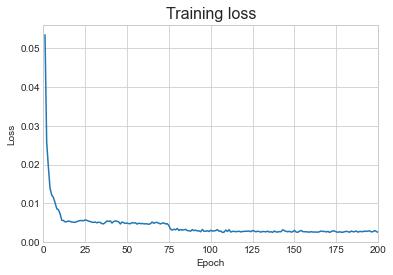

In [10]:
# Run training
epochs = 200
loss_plot = []
recon_plot = []
kld_plot = []
for t in range(epochs):
    kld_weight = 0.0003*(t/20 if t/20 <= 1 else 1)
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, model.loss_function, optimizer, loss_output = loss_plot, recon_output = recon_plot, kld_output = kld_plot, weight = kld_weight)
    test(test_dataloader, model, model.loss_function, weight = kld_weight)
print("Done!")

# Loss plot
plt.plot(range(1, epochs+1), loss_plot)
plt.ylabel('Loss')
plt.xlabel('Epoch') 
plt.title('Training loss', fontsize=16)
plt.xlim([0,epochs])
plt.show()

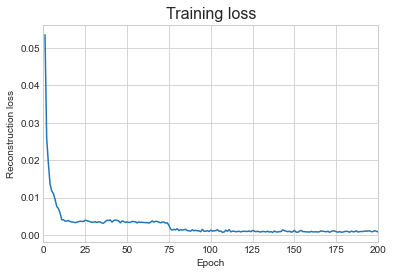

In [11]:
# Reconstruction loss plot
plt.plot(range(1, epochs+1), recon_plot)
plt.ylabel('Reconstruction loss')
plt.xlabel('Epoch') 
plt.title('Training loss', fontsize=16)
plt.xlim([0,epochs])
plt.show()

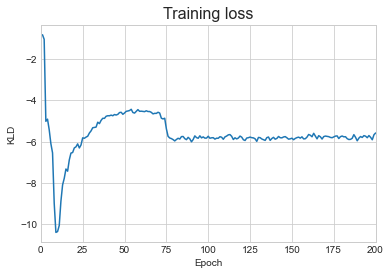

In [12]:
# KLD plot
plt.plot(range(1, epochs+1), kld_plot)
plt.ylabel('KLD')
plt.xlabel('Epoch') 
plt.title('Training loss', fontsize=16)
plt.xlim([0,epochs])
plt.show()

### 2.3 Saving the model

In [79]:
save_model = False
model_name = "VAE_MLP512_30_"+str(latent_dim)+"_manual.pth"

if save_model:
    trained_root = "./trained_models/"
    
    model_path = trained_root + model_name
    torch.save(model.state_dict(), model_path)
    print(f"Saved PyTorch Model State to {model_path}")

Saved PyTorch Model State to ./trained_models/VAE_MLP512_30_5_manual.pth


### 2.4 Loading the model

In [11]:
# For these sections, the CPU will be used
device = 'cpu'
model = AirfoilVAE(in_channels = in_channels,
            latent_dim = latent_dim,
            hidden_dims = hidden_dims).to(device)
model_root = "./trained_models/"
model_name = "VAE_MLP512_30_"+str(latent_dim)+"_manual.pth"

model_path = model_root + model_name
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

### 2.5 Making predictions on random airfoils

mu: [0.04884702 0.01198692 2.047626   0.6448984  0.20599924]
std: [0.99070996 0.97070473 0.16915329 0.12806249 0.07576117]
------ Comparison ------


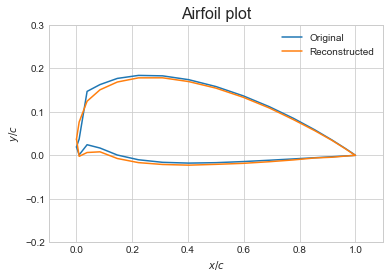

In [53]:
idxpred = np.random.randint(0, len(test_data))
x, y = test_data[idxpred][0].to(device), test_data[idxpred][1].to(device)
dummy = np.array([0, 0, 0, 0, 0, 0]) # Dummy variable to complete the dataset rows to 36 for plotting
with torch.no_grad():
    pred = model.forward(x)     # Returns [recons, input, mu, log_var]
    reconstructed = denormalize_data(np.concatenate((pred[0].cpu().numpy(), dummy), axis=0),scaler)
    original = denormalize_data(np.concatenate((pred[1].cpu().numpy(), dummy), axis=0),scaler)
    plot1 = plt.subplot2grid((1,3), (0,0), colspan = 3)
    print(f'mu: {pred[2].cpu().numpy()}')
    print(f'std: {np.exp(0.5*pred[3].cpu().numpy())}')
    print("------ Comparison ------")
    airfoil_plot(original, fig=plot1, label="Original")
    airfoil_plot(reconstructed, fig=plot1, label="Reconstructed")
    plt.show()

### 2.6 Generating random airfoils

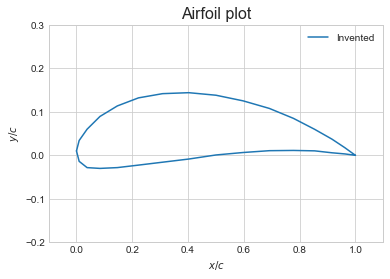

In [79]:
sampled = model.sample(1, 'cpu')
dummy = np.array([0, 0, 0, 0, 0, 0]) # Dummy variable to complete the dataset rows to 36 for plotting
with torch.no_grad():
    sampled = model.sample(1, 'cpu')     # Returns [norm_coords] of an invented airfoil
    invented = denormalize_data(np.concatenate((sampled[0].cpu().numpy(), dummy), axis=0),scaler)
    airfoil_plot(invented, label="Invented")
    plt.show()